In [189]:
import pandas as pd
import numpy as np
import seaborn as sns # data visualization
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, roc_auc_score, roc_curve


%matplotlib inline

### Data set

In [190]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv')

subsetFeatures = ['Make','Model','Year','Engine HP', 'Engine Cylinders', 'Transmission Type',
           'Vehicle Style', 'highway MPG', 'city mpg','MSRP']

df = df[subsetFeatures]

### Data preparation

In [191]:
df.columns = df.columns.str.replace(' ','_').str.lower()

In [192]:
df.isnull().sum()

make                  0
model                 0
year                  0
engine_hp            69
engine_cylinders     30
transmission_type     0
vehicle_style         0
highway_mpg           0
city_mpg              0
msrp                  0
dtype: int64

In [193]:
df['engine_cylinders']=df['engine_cylinders'].fillna(0)
df['engine_hp']=df['engine_hp'].fillna(0)

In [194]:
df['above_average']= (df['msrp']>=df['msrp'].mean()).astype(int)
df = df.drop(['msrp'], axis =1)

### Split Data 60% / 20% / 20%

In [195]:
df_full_train, df_test = train_test_split(df,test_size=0.2,random_state=1)
df_train, df_val = train_test_split(df_full_train,test_size=0.25,random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

del df_train['above_average']
del df_val['above_average']
del df_test['above_average']


## Question 1: ROC AUC feature importance
ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

* For each numerical variable, use it as score and compute AUC with the above_average variable.
* Use the training dataset for that

If your AUC is < 0.5, invert this variable by putting "-" in front (e.g. -df_train['engine_hp'])

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

#### Which numerical variable (among the following 4) has the highest AUC?

In [162]:
numerical = ['year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg'] 

In [163]:
scores = {}
for feature in numerical:

    auc = roc_auc_score(y_train, df_train[feature])
    
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[feature])
    
    scores[feature] = round(auc,3)
    print(f'{feature}: auc = {auc}')


year: auc = 0.687551492804683
engine_hp: auc = 0.9171031265539011
engine_cylinders: auc = 0.766116490165669
highway_mpg: auc = 0.6330587871772013
city_mpg: auc = 0.6734244643245233


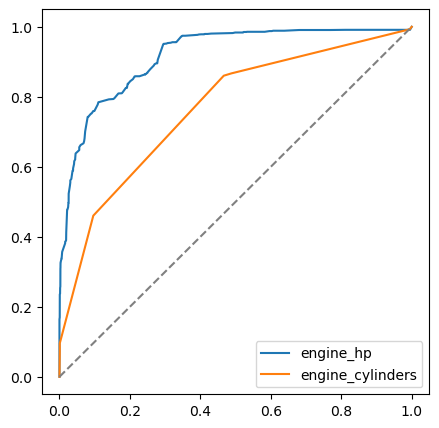

In [164]:
plt.figure(figsize=(5, 5))

fpr, tpr, _ = roc_curve(y_train, df_train.engine_hp)
plt.plot(fpr, tpr, label='engine_hp')

fpr, tpr, _ = roc_curve(y_train, df_train.engine_cylinders)
plt.plot(fpr, tpr, label='engine_cylinders')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

plt.legend()
plt.show()

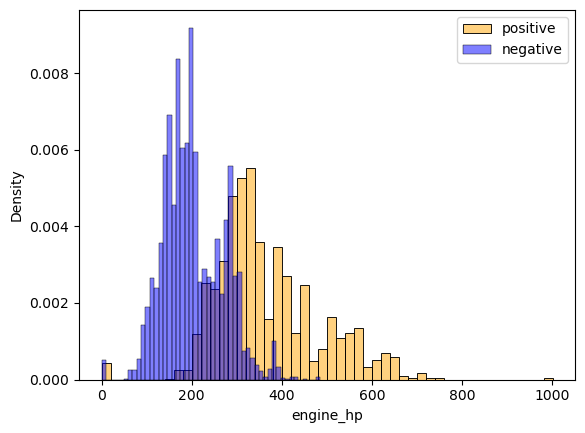

In [165]:
sns.histplot(df_train.engine_hp[y_train == 1],
             stat='density', bins=50,
             color='orange', alpha=0.5,
             label='positive')
sns.histplot(df_train.engine_hp[y_train == 0],
             stat='density', bins=50,
             color='blue', alpha=0.5,
             label='negative')

plt.legend()
plt.show()

### Question 2: Training the model
Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

##### What's the AUC of this model on the validation dataset? (round to 3 digits)

In [166]:
dv = DictVectorizer()

train_dict = df_train.to_dict(orient='records') #dictionary
X_train = dv.fit_transform(train_dict) ## Matrix from dict


model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:,1]
y_pred


array([0.65686766, 0.00692269, 0.36375281, ..., 0.0041994 , 0.99998882,
       0.06719429])

In [167]:
round(roc_auc_score(y_val, y_pred),3)

0.98

### Question 3: Precision and Recall
Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

#### At which threshold precision and recall curves intersect?


In [168]:
scores = []
thld = np.arange(0,1,0.01) 

for t in thld:
    actual_positives = (y_val ==1)
    actual_negatives = (y_val ==0)
    
    pred_positives = (y_pred >= t)
    pred_negatives = (y_pred < t)
    
    tp = (actual_positives & pred_positives).sum()
    tn = (actual_negatives & pred_negatives).sum()
    
    fp = (pred_positives & actual_negatives).sum()
    fn = (pred_negatives & actual_positives).sum()
    
    
    p = round(tp/(tp+fp),5)
    r = round(tp/(tp+fn),5)
    
    scores.append((t,tp,tn,fp,fn, p, r))

In [169]:
columns = ['threshold','tp','tn','fp','fn','precision','recall']
df_scores = pd.DataFrame(scores,columns=columns)

In [170]:
df_scores[::11]

,threshold,tp,tn,fp,fn,precision,recall
0,0.00,654,0,1729,0,0.27444,1.00000
11,0.11,644,1415,314,10,0.67223,0.98471
22,0.22,625,1530,199,29,0.75850,0.95566
33,0.33,604,1606,123,50,0.83081,0.92355
44,0.44,589,1646,83,65,0.87649,0.90061
55,0.55,565,1674,55,89,0.91129,0.86391
66,0.66,519,1692,37,135,0.93345,0.79358
77,0.77,473,1712,17,181,0.96531,0.72324
88,0.88,381,1726,3,273,0.99219,0.58257
99,0.99,192,1729,0,462,1.00000,0.29358


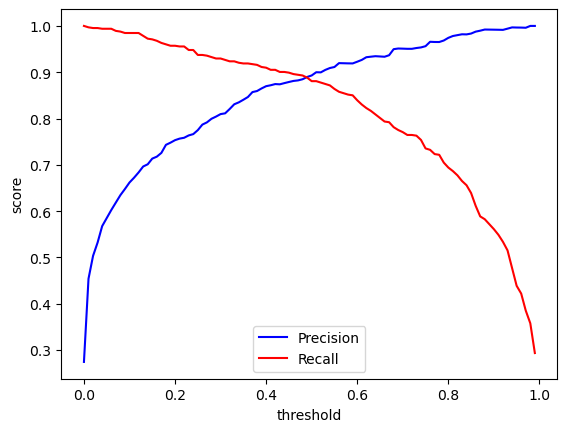

In [171]:
plt.plot(df_scores.threshold, df_scores.precision, label ='Precision', color = 'blue')
plt.plot(df_scores.threshold, df_scores.recall, label='Recall', color = 'red')

plt.xlabel('threshold')
plt.ylabel('score')

plt.legend()

In [172]:
x = df_scores.index[(df_scores.recall == df_scores.precision)].tolist()
df_scores.threshold.loc[x]

Series([], Name: threshold, dtype: float64)

Text(0, 0.5, 'Recall')

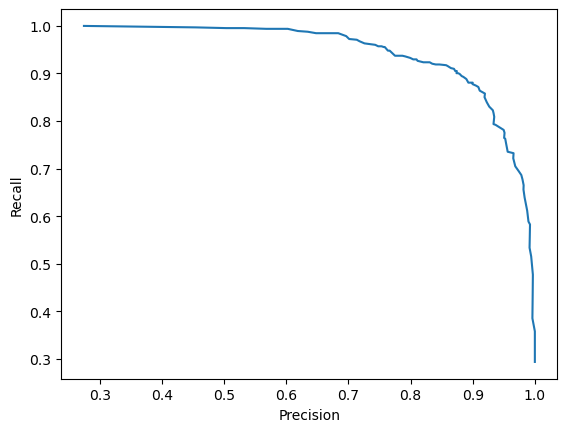

In [173]:
plt.plot(df_scores.precision, df_scores.recall)

plt.xlabel('Precision')
plt.ylabel('Recall')

### Question 4: F1 score
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

 F1 = 2 * (P*R)/(P+R)

Where P is precision and R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

##### At which threshold F1 is maximal?

In [174]:
df_scores['F1'] = 2 * (df_scores.precision * df_scores.recall) / (df_scores.precision + df_scores.recall)

df_scores[:10]

,threshold,tp,tn,fp,fn,precision,recall,F1
0,0.00,654,0,1729,0,0.27444,1.00000,0.430683
1,0.01,652,945,784,2,0.45404,0.99694,0.623924
2,0.02,651,1087,642,3,0.50348,0.99541,0.668720
3,0.03,651,1157,572,3,0.53230,0.99541,0.693661
4,0.04,650,1234,495,4,0.56769,0.99388,0.722626
5,0.05,650,1268,461,4,0.58506,0.99388,0.736544
6,0.06,650,1300,429,4,0.60241,0.99388,0.750143
7,0.07,647,1330,399,7,0.61855,0.98930,0.761180
8,0.08,646,1357,372,8,0.63458,0.98777,0.772730
9,0.09,644,1379,350,10,0.64789,0.98471,0.781556


In [175]:
max(df_scores.F1)

0.8902607357656691

In [176]:
df_scores.threshold[df_scores.F1 == max(df_scores.F1)]

51    0.51
Name: threshold, dtype: float64

In [177]:
df_scores.loc[df_scores.F1.argmax()]

threshold       0.510000
tp            576.000000
tn           1665.000000
fp             64.000000
fn             78.000000
precision       0.900000
recall          0.880730
F1              0.890261
Name: 51, dtype: float64

### Question 5: 5-Fold CV
Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)
* Iterate over different folds of df_full_train
* Split the data into train and validation
* Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
* Use AUC to evaluate the model on validation

#### How large is standard deviation of the scores across different folds?

In [206]:
def train(df_train, C=1.0):
    dv = DictVectorizer(sparse=False)
    
    train_dict = df_train.to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)
    
    model = LogisticRegression(solver='liblinear',C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df_val, dv, model):
    val_dict = df_val.to_dict(orient='records')
    X_val = dv.transform(val_dict)
    
    y_pred = model.predict_proba(X_val)[:,1]
    
    return y_pred

In [202]:
n = 5

scores =[]
kfold = KFold(n_splits=n,shuffle=True,random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    
    y_train = df_train.above_average.values
    y_val = df_val.above_average.values
    
    del df_train['above_average']
    del df_val['above_average']
    
    dv, model = train(df_train)
    y_pred = predict(df_val, dv, model)
    
    auc = roc_auc_score(y_val,y_pred)
    scores.append(auc)
    
print('%.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

0.979 +/- 0.002


In [204]:
df_full_train.columns

Index(['make', 'model', 'year', 'engine_hp', 'engine_cylinders',
       'transmission_type', 'vehicle_style', 'highway_mpg', 'city_mpg',
       'above_average'],
      dtype='object')

### Question 6: Hyperparameter Tuning
Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: [0.01, 0.1, 0.5, 10]
* Initialize KFold with the same parameters as previously
* Use these parameters for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

##### Which C leads to the best mean score?

In [214]:
n = 5
kfold = KFold(n_splits=n,shuffle=True,random_state=1)

for C in [0.01, 0.1, 0.5, 10]:
    scores =[]

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
    
        y_train = df_train.above_average.values
        y_val = df_val.above_average.values
    
        del df_train['above_average']
        del df_val['above_average']
    
        dv, model = train(df_train, C)
        y_pred = predict(df_val, dv, model)
    
        auc = roc_auc_score(y_val,y_pred)
        scores.append(auc)
    
    print('C=%5s, %.4f +/- %.4f' % (C, np.mean(scores), np.std(scores)))

C= 0.01, 0.9515 +/- 0.0025
C=  0.1, 0.9720 +/- 0.0018
C=  0.5, 0.9782 +/- 0.0033
C=   10, 0.9835 +/- 0.0031
